In [1]:
import matplotlib.pyplot as plt
import os
import cv2
import dlib
import numpy as np

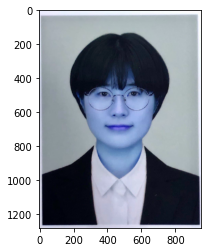

In [9]:
# 증명사진
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/photo.png'
# 마스크-인식 안됨
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/p1.png'
# 옆모습 - 각도 제한적, 스티커 로테이션 필요
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/p2.png'
# 거꾸로된 사진 - 인식 안됨
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/p3.png'
# 작은 사진 - 인식 안됨
#my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/p4.png'

img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

rectangles[[(290, 418) (675, 804)]]


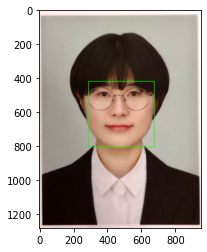

In [10]:
# dlib로 얼굴의 위치 알아내기
#hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# 박스 추출
# dlib은 rgb 이미지를 입력받기 때문에 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb,1)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

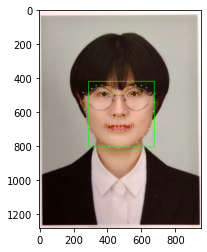

In [11]:
# face landmark - Dlib는 ibug 300w로 학습한 모델 제공 : 68개의 이목구비 위치를 찾는다
# 랜드마크 모델
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
#     print(points.parts())
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # points.parts() = points[(x,y), (x,y)...]이기 때문에 변환 필요
    list_landmarks.append(list_points)

# print(list_landmarks)

# 랜드마크 출력
for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 3, (0,255,255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(x,y) : (468,599)
(w,h) : (386,386)
img_sticker : (386, 386, 3)
(x,y) : (275,406)
x1, x2: 275, 661
y1, y2: 406, 792


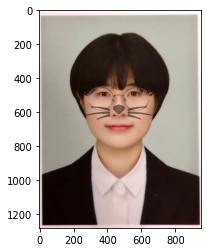

In [5]:
# 스티커 적용

# 코의 위치
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # 코끝index 30으로 잡음
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 스티커 가져와서 크기 위치 조정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

# 크기
img_sticker = cv2.resize(img_sticker, (w,h))
print ('img_sticker : {}'.format(img_sticker.shape))

# 위치
refined_x = x - w // 2
refined_y = y - h // 2
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#적용하기
x1 = refined_x
x2 = refined_x+img_sticker.shape[1]
y1 = refined_y
y2 = refined_y+img_sticker.shape[0]
print("x1, x2: {}, {}".format(x1, x2))
print("y1, y2: {}, {}".format(y1, y2))

sticker_area = img_bgr[y1:y2, x1:x2]
# img_bgr[y1:y2, x1:x2] = np.where(img_sticker, sticker_area, img_sticker).astype(np.uint8) #sticker==0 블랙 투명, ==1 전체출력
# plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
# plt.show()

#사진을 스티커모양으로 자름
img_bgr_sticker_shape = np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8) 
# addWeighted()를 이용하여 새로운 스티커로 만듦 (투명)
img_sticker_new=cv2.addWeighted(img_bgr_sticker_shape, 0.5, img_sticker, 0.5, 0)
# 합치기
img_bgr[y1:y2, x1:x2] = np.where(img_sticker, sticker_area, img_sticker_new).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#문제점 찾아보기
# 얼굴 각도에 따라 스티커의 각도도 바뀌어야 한다.
# 이미지가 너무 작거나 마스크를 쓴 경우 얼굴인지 인식이 안된다.
# 카메라스티커를 만든다면 실시간으로 인지되고 있는지와 어떻게 나오는지 보여주기 위해서는 실행 속도가 중요할 것 같다.
